Варіант 2
Контекст:
Вам надані дані про мобільні телефони. Ваше завдання візуально проаналізувати залежності в даних та зробити гіпотезу щодо факторів, які впливають на ціновий діапазон.
Файл містить змінні:
1.	Battery Power in mAh - Потужність батареї в мАг
2.	Has BlueTooth or not - Є Bluetooth чи ні
3.	Microprocessor clock speed - Тактова частота мікропроцесора
4.	The phone has dual sim support or not - Телефон підтримує дві сімки чи ні
5.	Front Camera Megapixels - Мегапікселі передньої камери
6.	Has 4G support or not - Є підтримка 4G чи ні
7.	Internal Memory in GigaBytes - Внутрішня пам'ять у гігабайтах
8.	Mobile Depth in Cm - Мобільна глибина в см
9.	Weight of Mobile Phone - Вага мобільного телефону
10.	Number of cores in the processor - Кількість ядер в процесорі
11.	Primary Camera Megapixels - Мегапікселі основної камери
12.	Pixel Resolution height - Висота роздільної здатності пікселів
13.	Pixel resolution width - Ширина роздільної здатності пікселя
14.	RAM in MB - Оперативна пам'ять в Мб
15.	Mobile screen height in cm - Висота мобільного екрана в см
16.	Mobile screen width in cm - Ширина мобільного екрана в см
17.	Longest time after a single charge - Найдовший час після одного заряду
18.	3g or not - 3g чи ні
19.	Has touch screen or not - Має сенсорний екран чи ні
20.	Has wifi or not - Є Wi-Fi чи ні
21.	Price Range - ціновий діапазон мобільних телефонів: 0 (низька вартість), 1 (середня вартість), 2 (висока вартість), 4 (дуже висока вартість)
Завдання:
1.	Завантажте дані у проект та зробіть merge даних
2.	Зробіть перевірку даних на консистентність та обробіть пропуски, якщо вони є
3.	Зробіть розвідувальний аналіз даних:
a.	Побудуйте кореляційну матрицю датасету та візуалізуйте її heatmap для цілей аналізу;
b.	Які топ-3 факторів впливають на цінову категорію найбільше, виходячи з кореляційного аналізу?


In [5]:
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from matplotlib import pyplot as plt


In [10]:
def udf_pearsonr(X, y):
    result = np.array([pearsonr(x, y) for x in X.T])
    return np.absolute(result[:,0]), result[:,1]

def organize(data, titles:[], target='price_range'):
    set_x = data.loc[:,titles]
    y = set_x[target]
    set_x = set_x.drop(target, axis=1)
    return np.array(set_x.values.tolist()),y.values.tolist()

def describe_(df):
    missing_data = df.isnull()

    data_isnotnull = [df[column][df[column] != np.nan].count() for column in df.columns]
    data_null = [max(data_isnotnull)-value for value in data_isnotnull]

    data = np.array([missing_data.columns, df.dtypes.values, data_isnotnull, data_null], dtype=str)
    headers= ["Name","Type","No Null", "Null"]

    print(tabulate(data.T, headers=headers))

In [11]:
df = pd.read_csv('tel_data_set_p_1.csv')
df.columns = [column.lower().replace("-", "_").replace(" ", "_") for column in df.columns]
df.replace('?', np.nan, inplace = True)
describe_(df)
df_tr = df[df.price_range < df.price_range.quantile(0.9)]

Name           Type       No Null    Null
-------------  -------  ---------  ------
battery_power  int64         2000       0
blue           int64         2000       0
clock_speed    float64       2000       0
dual_sim       int64         2000       0
fc             int64         2000       0
four_g         int64         2000       0
int_memory     int64         2000       0
m_dep          float64       2000       0
mobile_wt      int64         2000       0
n_cores        int64         2000       0
pc             int64         2000       0
px_height      int64         2000       0
px_width       int64         2000       0
ram            int64         2000       0
sc_h           int64         2000       0
sc_w           int64         2000       0
talk_time      int64         2000       0
three_g        int64         2000       0
touch_screen   int64         2000       0
wifi           int64         2000       0
price_range    int64         2000       0


In [12]:
selector = SelectKBest(udf_pearsonr, k=2)
selector_varianceThreshold = VarianceThreshold(0.25)

In [13]:
selected_data = selector_varianceThreshold.fit_transform(df_tr)
title_features = selector_varianceThreshold.get_feature_names_out(df_tr.columns)

X, y = organize(df_tr, title_features)

train_set = X
train_y = y
display(len(title_features))

14

In [21]:
for idx in range(train_set.shape[1]):
    title = title_features[idx].replace("_", " ").capitalize()
    pea_score, p_value = pearsonr(train_set[:,idx], train_y)
    print(f"{title} - кореляція є {round(np.abs(pea_score),3)}".format())

Battery power - кореляція є 0.104
Clock speed - кореляція є 0.01
Fc - кореляція є 0.039
Int memory - кореляція є 0.006
Mobile wt - кореляція є 0.035
N cores - кореляція є 0.015
Pc - кореляція є 0.03
Px height - кореляція є 0.092
Px width - кореляція є 0.08
Ram - кореляція є 0.855
Sc h - кореляція є 0.03
Sc w - кореляція є 0.003
Talk time - кореляція є 0.027


In [15]:
from sklearn.ensemble import RandomForestRegressor

<AxesSubplot:>

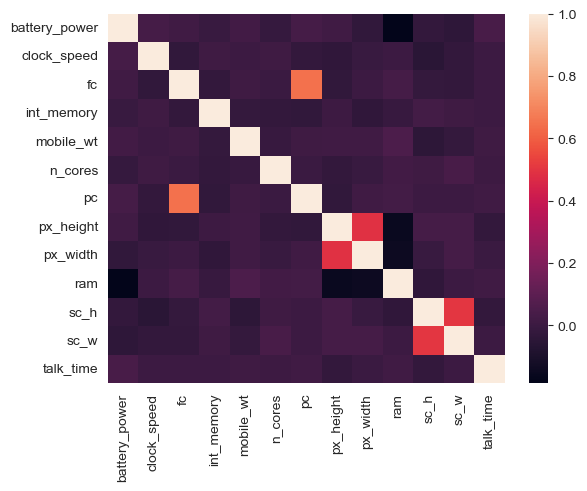

In [18]:
fig, ax = plt.subplots()
cln_date = df_tr[title_features]
correlation = cln_date.drop(["price_range"], axis=1).corr(min_periods=3)
correlation.set_index(correlation.columns, inplace=True)
correlation.to_csv('result_correlation.csv', encoding='utf-8', index=True)

sns.heatmap(correlation, ax=ax)

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Importences features')]

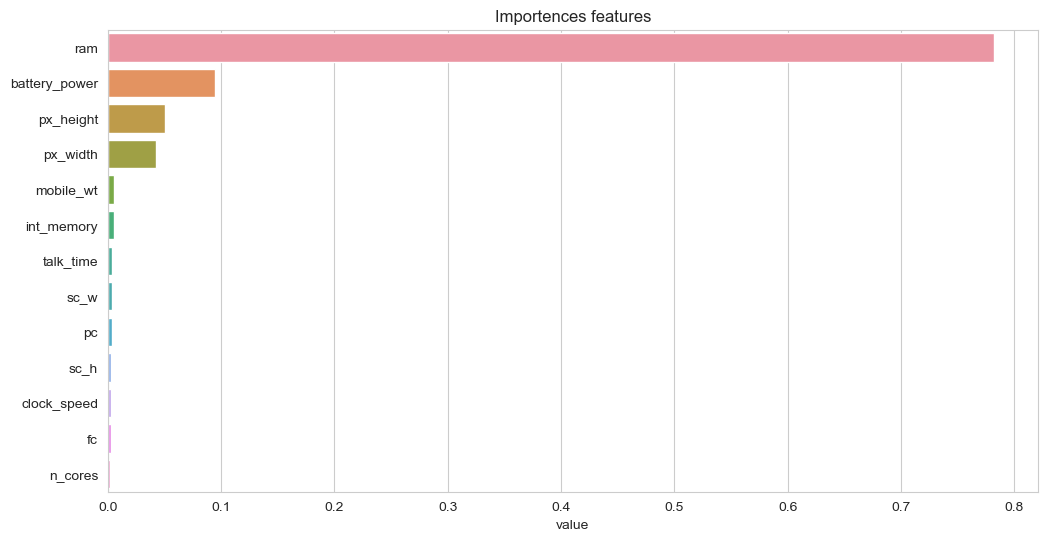

In [22]:
clf = RandomForestRegressor(n_estimators = 50, random_state = 123)
clf.fit(X, y)
fig, ax=plt.subplots(figsize=(12,6))
importances = clf.feature_importances_
indices =np.argsort(importances)
title="Importences features"
importences_features = pd.DataFrame(data={"value":importances, "title":np.array(title_features)[range(len(indices))]})
sns.barplot(data=importences_features.sort_values("value",ascending=False ), x="value", y="title")
ax.set(ylabel=None, title=title)